Results for Section 4.1

In [1]:
import json
import os
import re
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import scipy.stats
import pandas as pd
%matplotlib inline
plt.rcParams["figure.dpi"] = 150
BASE_PATH = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
OUTPUT_PATH = os.path.abspath(os.path.join(os.getcwd(), 'figures'))

matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

In [2]:
# Adapted from https://towardsdatascience.com/making-matplotlib-beautiful-by-default-d0d41e3534fd
sns.set(font='Helvetica',
        rc={
 'axes.axisbelow': False,
 'axes.edgecolor': 'lightgrey',
 'axes.facecolor': 'None',
 'axes.grid': True,
 'axes.axisbelow': True,
 'grid.color': 'lightgrey',
 'axes.labelcolor': 'dimgrey',
 'axes.spines.right': False,
 'axes.spines.top': False,
 'figure.facecolor': 'white',
 'lines.solid_capstyle': 'round',
 'patch.edgecolor': 'w',
 'patch.force_edgecolor': True,
 'text.color': 'dimgrey',
 'xtick.bottom': False,
 'xtick.color': 'dimgrey',
 'xtick.direction': 'out',
 'xtick.top': False,
 'ytick.color': 'dimgrey',
 'ytick.direction': 'out',
 'ytick.left': False,
 'ytick.right': False})
sns.set_context("notebook", rc={"font.size":14,
                                "axes.titlesize":16,
                                "axes.labelsize":13})

In [3]:
import glob

experiments = {
    "S3": "s3",
    "DynamoDB": "dynamodb",
    "Redis":  "redis",
    "TCP": "tcp",
}

dfs = []
for experiment_name, exp_base_path in experiments.items():
    var_base_path = os.path.join(BASE_PATH, 'results', 'p2p', exp_base_path, "results")
    print(var_base_path)

    for f in glob.glob(os.path.join(var_base_path, '*_producer_times')):
        df = pd.read_csv(f, skiprows=1, header=None, names=['rtt'])
        df['type'] = experiment_name
        df['size'] = int(f.split('_')[-3])
        dfs.append(df)
        
df = pd.concat(dfs)
# convert into ms
df['rtt'] /= 2 * 1000
print(df)

/work/serverless/2022/collectives/serverless-collectives-artifact/results/p2p/s3/results
/work/serverless/2022/collectives/serverless-collectives-artifact/results/p2p/dynamodb/results
/work/serverless/2022/collectives/serverless-collectives-artifact/results/p2p/redis/results
/work/serverless/2022/collectives/serverless-collectives-artifact/results/p2p/tcp/results
         rtt type    size
0    52.0465   S3  100000
1    64.8540   S3  100000
2    57.2800   S3  100000
3    46.3100   S3  100000
4    57.0305   S3  100000
..       ...  ...     ...
995   0.3730  TCP    1000
996   0.3555  TCP    1000
997   0.3715  TCP    1000
998   0.3265  TCP    1000
999   0.3405  TCP    1000

[23300 rows x 3 columns]


## Plot P2P Bandwidth

         rtt type    size        bw  size_kb
0    52.0465   S3  100000  1.921359    100.0
1    64.8540   S3  100000  1.541925    100.0
2    57.2800   S3  100000  1.745810    100.0
3    46.3100   S3  100000  2.159361    100.0
4    57.0305   S3  100000  1.753448    100.0
..       ...  ...     ...       ...      ...
995   0.3730  TCP    1000  2.680965      1.0
996   0.3555  TCP    1000  2.812940      1.0
997   0.3715  TCP    1000  2.691790      1.0
998   0.3265  TCP    1000  3.062787      1.0
999   0.3405  TCP    1000  2.936858      1.0

[23300 rows x 5 columns]


'created' timestamp seems very low; regarding as unix timestamp
Zapf NOT subset; don't know how to subset; dropped
morx NOT subset; don't know how to subset; dropped


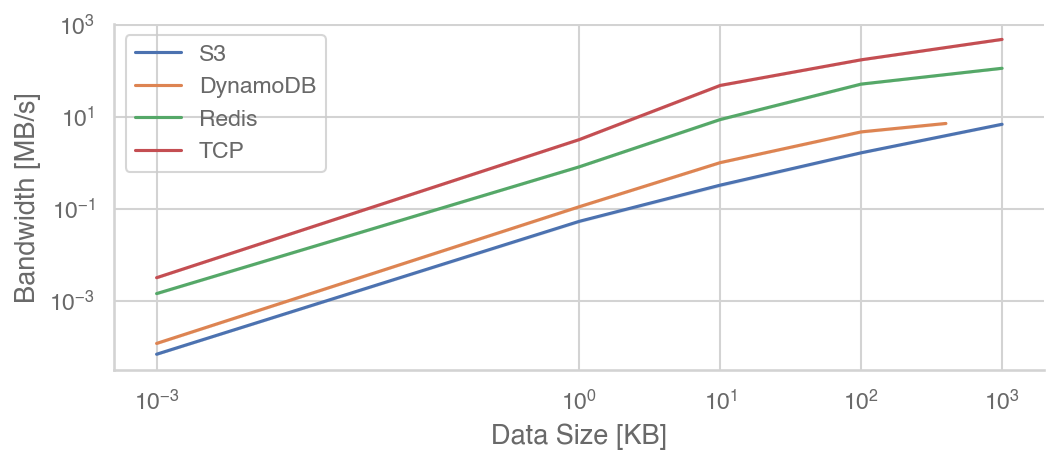

In [8]:
p2p_experiment_means = {}
p2p_experiment_cis = {}
fig = plt.figure(figsize=(8,3))
#ax, ax2 = fig.add_subplot(), fig2.add_subplot()
exp_analysis = experiments.copy()

df['bw'] = df['size'] / df['rtt'] / 1000
print(df)

df['size_kb'] = df['size'] / 1000

data = df.loc[df['size_kb'] <= 1000.0]

ax = sns.lineplot(data=data, x='size_kb', y='bw', hue='type', estimator=np.median)

ax.set_xscale('log')
ax.set_xlabel("Data Size [KB]")
#print(list(plot_data.keys()))
ax.set_xticks([0.001, 1.0, 10.0, 100.0, 1000.0])#list(plot_data.keys()))
#ax2.set_xticklabels(format_xticks(plot_data.keys()))
ax.set_ylabel("Bandwidth [MB/s]")
ax.set_yscale('log')

ax.legend()
fig.savefig(os.path.join(OUTPUT_PATH, "p2p_bandwidth.pdf"), bbox_inches='tight')
plt.show()


## Plot P2P Latency

/tmp/ipykernel_989595/59397849.py:23: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
'created' timestamp seems very low; regarding as unix timestamp
Zapf NOT subset; don't know how to subset; dropped
morx NOT subset; don't know how to subset; dropped


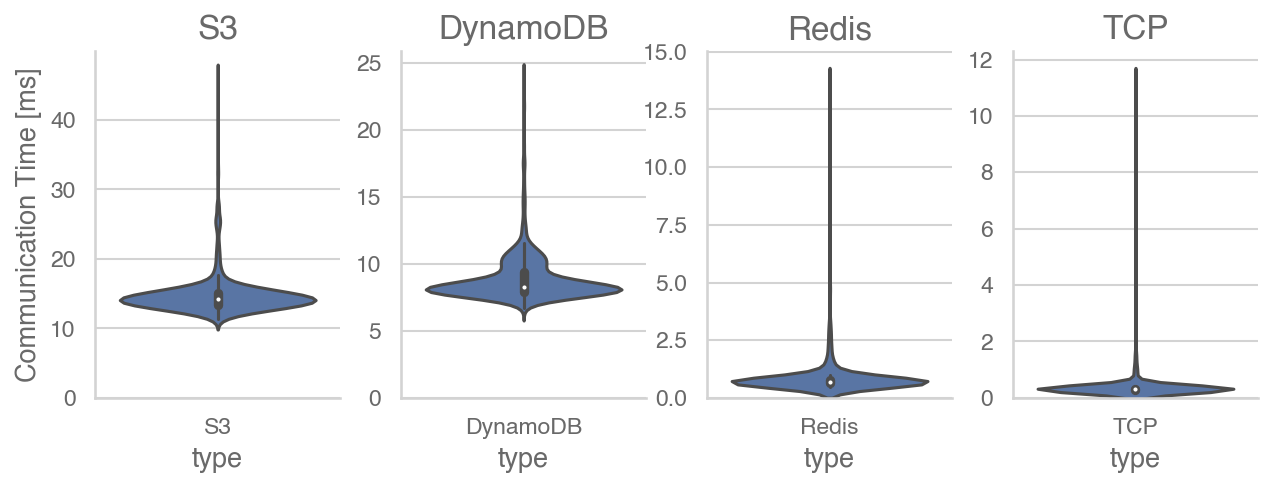

In [5]:
fig = plt.figure(figsize=(10,3))
gs = matplotlib.gridspec.GridSpec(1, 4, wspace=0.25, hspace=0.5) # 2x2 grid
axes = []
axes.append(fig.add_subplot(gs[0, 0]))
axes.append(fig.add_subplot(gs[0, 1]))
axes.append(fig.add_subplot(gs[0, 2]))
axes.append(fig.add_subplot(gs[0, 3]))
i = 0
exp_analysis = experiments.copy()
for experiment_name, exp_base_path in exp_analysis.items():
    ax = axes[i]
    ax.set_title(experiment_name)
    #print(experiment_name)
    data = df.loc[(df['size'] == 1) & (df['type'] == experiment_name)]
    #print(data)
    sns.violinplot(data=data, x='type',y='rtt',ax=ax)
    if experiment_name == 'S3':
        ax.set_ylabel('Communication Time [ms]')
    else:
        ax.set_ylabel('')
    ax.set_ylim(0)
    i += 1
fig.show()
fig.savefig(os.path.join(OUTPUT_PATH, "p2p_variance_1b.pdf"), bbox_inches='tight')

/tmp/ipykernel_989595/362352342.py:21: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  print(data.median())
/tmp/ipykernel_989595/362352342.py:22: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  print(data.mean())
/tmp/ipykernel_989595/362352342.py:21: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  print(data.median())
/tmp/ipykernel_989595/362352342.py:22: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this 

S3
rtt            144.662250
size       1000000.000000
bw               6.912653
size_kb       1000.000000
dtype: float64
rtt            146.258418
size       1000000.000000
bw               7.161775
size_kb       1000.000000
dtype: float64
Redis
rtt              8.80650
size       1000000.00000
bw             113.55249
size_kb       1000.00000
dtype: float64
rtt              9.157337
size       1000000.000000
bw             110.577037
size_kb       1000.000000
dtype: float64
TCP
rtt              2.077750
size       1000000.000000
bw             481.289864
size_kb       1000.000000
dtype: float64
rtt              5.394508
size       1000000.000000
bw             445.040561
size_kb       1000.000000
dtype: float64


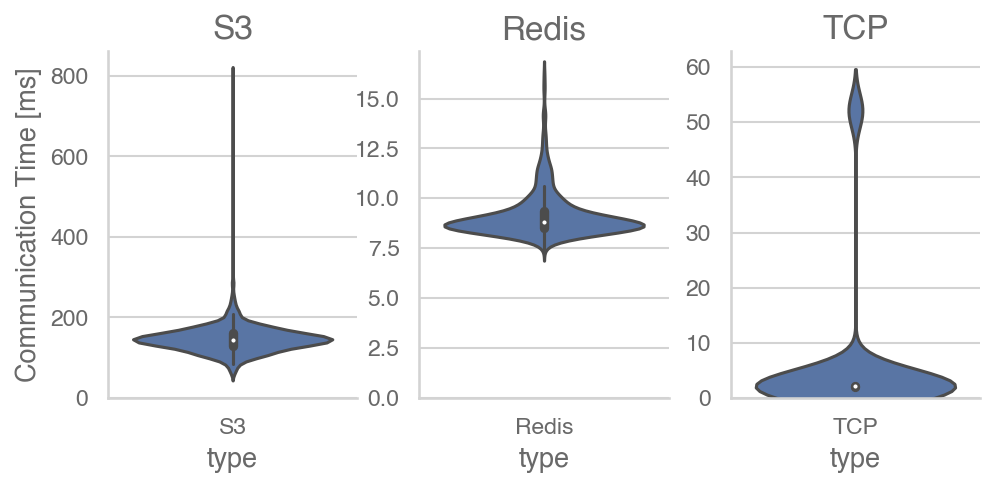

In [6]:
fig = plt.figure(figsize=(7.5,3))
gs = matplotlib.gridspec.GridSpec(1, 3, wspace=0.25, hspace=0.5) # 2x2 grid
axes = []
axes.append(fig.add_subplot(gs[0, 0]))
axes.append(fig.add_subplot(gs[0, 1]))
axes.append(fig.add_subplot(gs[0, 2]))
#axes.append(fig.add_subplot(gs[0, 3]))
i = 0
exp_analysis = experiments.copy()

for experiment_name, exp_base_path in exp_analysis.items():
    
    if experiment_name == 'DynamoDB':
        continue
    
    ax = axes[i]
    ax.set_title(experiment_name)
    #print(experiment_name)
    data = df.loc[(df['size'] == 1000*1000) & (df['type'] == experiment_name)]
    print(experiment_name)
    print(data.median())
    print(data.mean())
    #data = data.head(100)
    #print(data)
    sns.violinplot(data=data, x='type',y='rtt',ax=ax)
    if experiment_name == 'S3':
        ax.set_ylabel('Communication Time [ms]')
    else:
        ax.set_ylabel('')
    ax.set_ylim(0)
    i += 1
fig.show()
fig.savefig(os.path.join(OUTPUT_PATH, "p2p_variance_1MB.pdf"), bbox_inches='tight')

## Analysis

In [9]:
print('Latency')
print(df.loc[df['size_kb'] == 0.001].groupby(['type','size_kb']).mean()['rtt'])
print(df.loc[df['size_kb'] == 0.001].groupby(['type','size_kb']).median()['rtt'])

Latency
type      size_kb
DynamoDB  0.001       8.902041
Redis     0.001       0.885513
S3        0.001      14.770029
TCP       0.001       0.392574
Name: rtt, dtype: float64
type      size_kb
DynamoDB  0.001       8.30625
Redis     0.001       0.68750
S3        0.001      14.24600
TCP       0.001       0.31050
Name: rtt, dtype: float64
